# Analyzing network packet process
### - *Finding the right buffer size of a server.* -

In this notebook we'll use network packet simulation and [possion process](https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459) to simulate network packet processing of a server which has a fixed buffer size.
If the buffer size is too small, the probability that a server will drop a request will increase. On the other hand if the buffer size is too big, computer resource is being wasted causing unnecessary costs.  
This goes the same to the speed of process. We use $beta$ for the speed which is defined as  

$$ beta =  \frac{incoming request per unit time}{processing time}$$  
We'll use discrete event simulation approach to find good enough value for these resource.  
Below is definition of descrete event simulation (DES). This slide is taken from one of my favorite moocs on [simulation and modeling](https://www.coursera.org/learn/modeling-simulation-natural-processes/)
![des](./img/des.png)

Objec oriented Implementation of DES for our model is as follow.

In [1]:
import numpy as np
from events import Event, EventQueue


class Buffer:
    def __init__(self, size):
        self.size = size # constant size of buffer
        self.Q = 0 # queue of packets. 
        self.t = 0 # time tracker
        self.dropped = 0 # number of dropped packets.
    def is_empty(self):
        if self.Q == 0:
            return True
        else:
            return False
    
    def available(self):
        if self.Q < self.size:
            return True
        else:
            return False
        
    def time(self, dT=0):
        self.t += dT
        return self.t
    def set_time(self, T):
        self.t = T
    
    def enQ(self):
        self.Q += 1
        
    def deQ(self):
        self.Q -= 1
    
    def drop(self):
        self.dropped += 1
        
    def num_dropped(self):
        return self.dropped

    def reset(self):
        self.Q = 0
        self.dropped = 0

class arrival(Event):
    def __init__(self, arrival_time, process_time):
        self.t = arrival_time
        self.process_time = process_time
    def action(self, queue, buffer):
        if buffer.is_empty():
            buffer.enQ()
            buffer.set_time(self.t + self.process_time)
            queue.insert(returned((buffer.time())))
        elif buffer.available():
            buffer.enQ()
            queue.insert(returned(buffer.time(dT = self.process_time)))
        else:
            buffer.drop()

class returned(Event):
    def __init__(self, processed_time):
        self.t = processed_time
    def action(self, queue, buffer):
        buffer.deQ()
        


Now lets build a tester function to run multiple tests.
Our tester function will take four inputs:

- buffer_size: size of the buffer object. (int) 
- rps: average requests per second. (float) 
- num_packets: number of packets sent per test. (int) 
- num_tests: number of tests to run with given parameters. (int)


In [2]:

def tester(buffer_size, rps, num_packets = 100, num_tests = 1000):
    
    # we are testing in milliseconds
    # or milli unit time, as it can be scaled naturally.
    lam = rps/1000
    
    # beta is average time interval between two arrival events. (measured compared to processing speed)
    beta = 1/lam
    
    # just using Rayleigh distribution for processing time of requests. 
    # Can play around with other distributions such as Maxwell-Boltzmann.
    arrival_times = np.random.exponential(beta, (num_tests, num_packets))
    process_times = np.random.rayleigh(1, (num_tests, num_packets)) 
    
    buffer = Buffer(buffer_size)
    dropped = np.zeros(num_tests)
    
    for i in range(num_tests):
        arrival_time = 0
        Q = EventQueue()
        for j in range(num_packets):
            arrival_time += arrival_times[i,j]
            process_time = process_times[i,j]
            Q.insert(arrival(arrival_time, process_time))
        
        while Q.notEmpty():
            e = Q.next()
            e.action(Q, buffer)
        
        dropped[i] = buffer.num_dropped()
        buffer.reset() # restarting buffer for next test.
        Q.reset() # restarting queue for next test.
    return dropped

Lets take our first test on wide range of values.

In [3]:
from tqdm import tqdm # this cell may take a few minutes.
num_tests = 10
num_packets = 10000
buffer_sizes = range(25,525,25)
rpss = range(250,2250,100)
table = np.zeros((20,20,num_tests))
for i in tqdm(range(20)):
    for j, rps in enumerate(rpss):
        table[i,j] = tester(buffer_sizes[i], rps, num_packets=num_packets, num_tests=num_tests)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.62s/it]


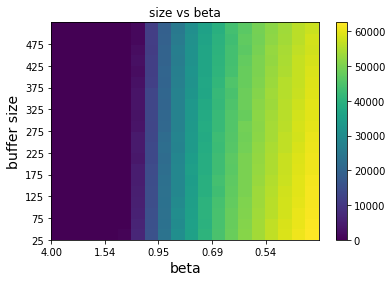

In [16]:
import matplotlib
import matplotlib.pyplot as plt

plt.pcolor(table.sum(axis = 2))


plt.xticks(range(0,20,4), ['{0:.2f}'.format(1000/rpss[i]) for i in range(0,20,4)])
plt.yticks(range(0,20,2), [buffer_sizes[i] for i in range(0,20,2)])

formatter = matplotlib.ticker.FormatStrFormatter('%1.1f')

plt.xlabel('beta', fontsize=14)
plt.ylabel('buffer size', fontsize=14)
plt.title('size vs beta')
plt.colorbar()
plt.show()

The above graph shows if $beta$ is smaller than $ 1  $, increasing the size of buffer doesn't help much.  
This is expected because $beta$ is average time interval between packets and $1$ is average processing time of each packet.  
If $ beta < 1 $ we have to Increase speed of the server.  
Now we'll explore more useful cases where beta is near 1

In [5]:
ps = [1.1, 1, 0.95, 0.9, 0.8, 0.7, 0.5]
betas = {}
for p in ps:
    beta = np.zeros((200,num_tests))
    betas[p] = beta
    for i in tqdm(range(200)):
        beta[i] = tester(i, 1000*p, num_packets=num_packets, num_tests=num_tests)



100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:53<00:00,  1.15it/s]


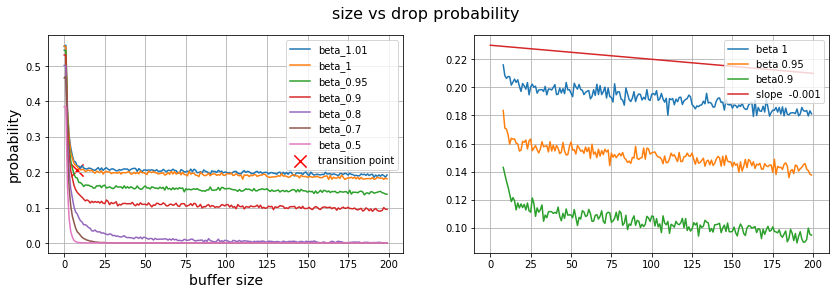

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))
for p in ps:
    beta = betas[p]
    ax1.plot(range(200),beta.sum(axis = 1)/100000, label= 'beta_' + str(p))
ax1.set_xlabel('buffer size', fontsize = 14)
ax1.set_ylabel('probability', fontsize = 14)
fig.suptitle('size vs drop probability', fontsize = 16)
ax1.grid()
ax1.scatter([8],[0.205], c = 'r', marker= 'x', s=150, label = 'transition point')
ax1.legend()
ax2.plot
ax2.plot(range(8,200),betas[1].sum(axis = 1)[8:]/100000, label = 'beta 1')
ax2.plot(range(8,200),betas[0.95].sum(axis = 1)[8:]/100000, label = 'beta 0.95')
ax2.plot(range(8,200),betas[0.9].sum(axis = 1)[8:]/100000, label = 'beta0.9')
ax2.plot([0,200],[0.23,0.21], label= 'slope  -0.0001')
ax2.legend()
ax2.grid()
plt.show()

Above figure illustrates relationship between buffer size and drop probability.  
- Left figure plots this relation with betas near critical value 1.  
- Right figure focuses on where buffer is bigger than the transition point and also plotted a helper line.  
- The slope of this helper line is is -0.0001 which is a very neat number. Is this a coincedence? 

With drop probability $ P(n) $, where $n$ is the buffer size, we can define
$$S(n+1) = P(n) - P(n+1)$$ the probability of saving a request by incrementing the buffer size by one.  
From the above graph with $0.9 \leq beta \leq 1$ and after some small number we have, $$S(n) \approx 0.0001$$ and surprisingly this value $0.001$ is remains a good approximation between different betas.  
This is not a coincedence! Consider the following test run.  
If we were to send 10000 packets almost simultaneously only the first $n$ request will be processed and the rest will be dropped giving  
$$ P_{10000}(n) = \frac{n}{10000},$$  
$$S_{10000}(n) = 0.0001 $$  
From this we see this slope originates from testing parameter, namely num_packets and not intrinsic to the model.

## Conclusion 
- After the transition point, increasing the buffer size doesn't help decrease dropping probability.
- Only decreasing beta, that is increasing the processing speed.
- Maintaining $beta < 0.7$, and a reasonable buffer size $n < 25$ is enough. More than this seems to be overkill.

All the codes for the simulation is saved in network_packet.py.  
Feel free to make improvements and share.  

Made by Hyunkun Kim.  
2019-AUG